Epoch 1: Training complete.
Epoch 2: Training complete.
Epoch 3: Training complete.
Epoch 4: Training complete.
Epoch 5: Training complete.
Epoch 6: Training complete.
Epoch 7: Training complete.
Epoch 8: Training complete.
Epoch 9: Training complete.
Epoch 10: Training complete.
KS-Test Statistic: 0.8521172637261167, P-value: 0.0


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


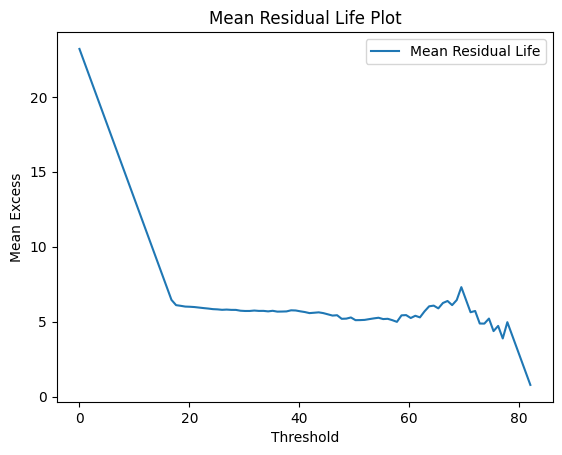

Average Negative Log-Likelihood (NLL): 4.3858 ± 0.0346


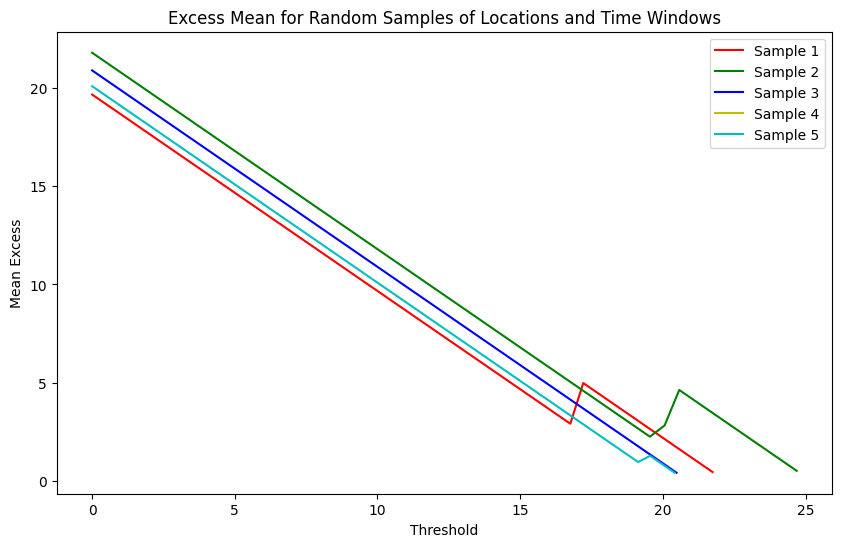

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from scipy.stats import kstest
import matplotlib.pyplot as plt

# ----------------------------------------
# 2. Model Implementation
# ----------------------------------------

class DeepSet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(DeepSet, self).__init__()
        self.phi = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )
        self.rho = nn.Sequential(
            nn.Linear(hidden_dim, output_dim),
            nn.ReLU()
        )

    def forward(self, x):
        # x: [batch_size, set_size, input_dim]
        phi_output = self.phi(x)
        set_representation = phi_output.mean(dim=1)  # Aggregate over set
        output = self.rho(set_representation)
        return output

class DeepGPD(nn.Module):
    def __init__(self, set_input_dim, vector_input_dim, hidden_dim):
        super(DeepGPD, self).__init__()
        self.deep_set = DeepSet(set_input_dim, hidden_dim, hidden_dim)
        self.fc_vector = nn.Sequential(
            nn.Linear(vector_input_dim, hidden_dim),
            nn.ReLU()
        )
        self.fc_final = nn.Linear(2 * hidden_dim, 2)  # Output shape and scale

    def forward(self, set_input, vector_input):
        set_output = self.deep_set(set_input)  # Shape: [batch_size, hidden_dim]
        vector_output = self.fc_vector(vector_input)  # Shape: [batch_size, hidden_dim]
        combined = torch.cat([set_output, vector_output], dim=1)  # Shape: [batch_size, 2 * hidden_dim]
        output = self.fc_final(combined)  # Shape: [batch_size, 2]
        return output

# ----------------------------------------
# 3. Training and Loss Function
# ----------------------------------------

def gpd_loss(y_true, xi, sigma):
    # Negative log-likelihood for GPD
    epsilon = 1e-6  # Avoid log(0) and negative values
    xi = torch.clamp(xi, min=-0.99, max=0.99)  # Ensure xi is within a valid range for GPD
    sigma = torch.clamp(sigma, min=epsilon)  # Ensure sigma is positive

    term1 = torch.log(sigma + epsilon)
    term2 = (1 + 1 / xi) * torch.log(1 + xi * y_true / sigma + epsilon)

    # Handle cases where 1 + xi * y_true / sigma can go negative (invalid GPD condition)
    term2 = torch.where(term2 > 0, term2, torch.zeros_like(term2))

    return torch.mean(term1 + term2)

# ----------------------------------------
# 4. Evaluation Metrics
# ----------------------------------------

def evaluate_model(model, test_loader):
    model.eval()
    true_excesses = []
    predicted_excesses = []
    nll_values = []
    with torch.no_grad():
        for set_input, vector_input, y_true in test_loader:
            xi, sigma = model(set_input, vector_input).chunk(2, dim=1)
            sigma = sigma.abs()  # Ensure sigma is positive

            predicted = sigma * (1 + xi * y_true / sigma)
            true_excesses.extend(y_true.numpy())
            predicted_excesses.extend(predicted.numpy().flatten())  # Flatten predicted values

            # Calculate NLL for the batch
            nll = gpd_loss(y_true, xi, sigma)
            nll_values.append(nll.item())

    # Perform KS-Test on the predicted excesses and true excesses
    if len(predicted_excesses) > 0 and len(true_excesses) > 0:
        ks_stat, p_value = kstest(predicted_excesses, 'genpareto', args=(0, np.mean(true_excesses), np.std(true_excesses)))
        print(f"KS-Test Statistic: {ks_stat}, P-value: {p_value}")
    else:
        print("Insufficient data for KS-Test.")

    # Plot Mean Residual Life
    if len(true_excesses) > 0:
        plt.figure()
        thresholds = np.linspace(0, max(true_excesses), 100)
        mean_residuals = [np.mean([x - t for x in true_excesses if x > t]) for t in thresholds]
        plt.plot(thresholds, mean_residuals, label="Mean Residual Life")
        plt.xlabel("Threshold")
        plt.ylabel("Mean Excess")
        plt.title("Mean Residual Life Plot")
        plt.legend()
        plt.show()

    # Report Average NLL with standard deviation
    avg_nll = np.mean(nll_values)
    std_nll = np.std(nll_values)
    print(f"Average Negative Log-Likelihood (NLL): {avg_nll:.4f} ± {std_nll:.4f}")

# ----------------------------------------
# Main Training and Testing Loop
# ----------------------------------------

# Dummy DataLoader Implementation
class GPDataset(Dataset):
    def __init__(self, combined_data):
        self.combined_data = combined_data

    def __len__(self):
        return len(self.combined_data)

    def __getitem__(self, idx):
        row = self.combined_data.iloc[idx]
        set_input = torch.tensor([row["ConvectivePrecipRate"], row["SolarRadiationFlux"]], dtype=torch.float32)
        vector_input = torch.tensor([row["RelativeHumidity"], row["SeaLevelPressure"]], dtype=torch.float32)
        y_true = torch.tensor(row["Excess"], dtype=torch.float32)
        return set_input.unsqueeze(0), vector_input, y_true

# Prepare DataLoaders
combined_data = pd.read_csv("/content/ghcn_combined_500.csv")  # Load pre-generated data
train_data = combined_data.sample(frac=0.8, random_state=42)
test_data = combined_data.drop(train_data.index)

train_loader = DataLoader(GPDataset(train_data), batch_size=32, shuffle=True)
test_loader = DataLoader(GPDataset(test_data), batch_size=32, shuffle=False)

# Model, Optimizer, and Training
model = DeepGPD(set_input_dim=2, vector_input_dim=2, hidden_dim=64)
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(10):
    model.train()
    for set_input, vector_input, y_true in train_loader:
        optimizer.zero_grad()
        xi, sigma = model(set_input, vector_input).chunk(2, dim=1)
        sigma = sigma.abs()  # Ensure sigma is positive
        loss = gpd_loss(y_true, xi, sigma)
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}: Training complete.")

# Evaluate the model
evaluate_model(model, test_loader)

# ----------------------------------------
# Excess Mean for Random Samples
# ----------------------------------------

def plot_excess_mean_random_samples(combined_data, num_samples=5, window_size=10):
    colors = ['r', 'g', 'b', 'y', 'c']
    plt.figure(figsize=(10, 6))

    for i in range(num_samples):
        # Randomly sample a subset of data
        sample_data = combined_data.sample(window_size)
        true_excesses = sample_data["Excess"].values

        # Compute mean excess
        thresholds = np.linspace(0, max(true_excesses), 50)
        mean_excess = [np.mean([x - t for x in true_excesses if x > t]) for t in thresholds]

        plt.plot(thresholds, mean_excess, label=f"Sample {i+1}", color=colors[i % len(colors)])

    plt.xlabel("Threshold")
    plt.ylabel("Mean Excess")
    plt.title("Excess Mean for Random Samples of Locations and Time Windows")
    plt.legend()
    plt.show()

# Plot excess mean for random samples
plot_excess_mean_random_samples(combined_data)